In [354]:
import numpy as np
import matplotlib.pyplot as plt
import json
path='/home/e.sharaborin/results/tube/res22_adaptffsu/upd_calc/'
fn = 'r_over_x_t=16.1542.csv'
# fn = 'r_over_x_t=11.9414.csv'

f_name=path + fn

with open(f_name, 'r') as f:
    lists = json.load(f)
    x, y, x_box_smooth, y_box_smooth, x_sorted, y_sorted = np.array(lists[0]), np.array(lists[1]), np.array(lists[2]), np.array(lists[3]), np.array(lists[4]), np.array(lists[5])

In [109]:
# crop, renormalize

x, y = x[y>0.3], y[y>0.3]

def smoother_vf(xin, yin, N_polynomials = 20, sigma = 1):
    xin_min = min(xin)
    xin_max = max(xin)
    yin_min = min(yin)
    yin_max = max(yin)
    
    x = (xin - xin_min)/(xin_max - xin_min)
    y = (yin - yin_min)/(yin_max - yin_min)

    x = x.reshape((len(x), 1))
    D = np.hstack([np.cos(2*np.pi*x*i) for i in range(N_polynomials)] + [np.sin(2*np.pi*x*i) for i in range(N_polynomials)])
    w = np.linalg.inv(D.T @ D + sigma*np.eye(2*N_polynomials)) @ D.T @ y
    
    X = np.linspace(min(x), max(x), 1000)

    X = X.reshape((len(X), 1))
    D = np.hstack([np.cos(2*np.pi*X*i)for i in range(N_polynomials)] + [np.sin(2*np.pi*X*i) for i in range(N_polynomials)])
    Y = D @ w
    
    plt.plot(x, y, ".", color="grey", alpha=0.3, label="data")
    plt.plot(X, Y, color="red", label="fit")
    plt.legend();
    
    return (x + xin_min)*(xin_max - xin_min), (y + yin_min)*(yin_max - yin_min)
    
x = (x - min(x))/(max(x) - min(x))
y = (y - min(y))/(max(y) - min(y))

# x = x - np.mean(x)
# y = y - np.mean(y)

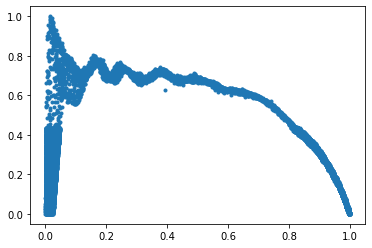

In [110]:
plt.plot(x, y, ".")

In [96]:
N_polynomials = 20
sigma = 1

x = x.reshape((len(x), 1))
D = np.hstack([np.cos(2*np.pi*x*i) for i in range(N_polynomials)] + [np.sin(2*np.pi*x*i) for i in range(N_polynomials)])

w = np.linalg.inv(D.T @ D + sigma*np.eye(2*N_polynomials)) @ D.T @ y

In [97]:
X = np.linspace(min(x), max(x), 1000)

X = X.reshape((len(X), 1))
D = np.hstack([np.cos(2*np.pi*X*i)for i in range(N_polynomials)] + [np.sin(2*np.pi*X*i) for i in range(N_polynomials)])
Y = D @ w

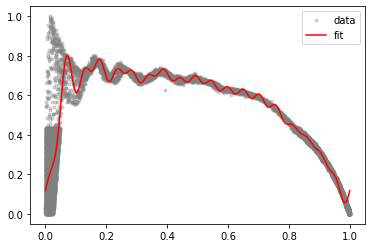

In [100]:
plt.plot(x, y, ".", color="grey", alpha=0.3, label="data")
plt.plot(X, Y, color="red", label="fit")
plt.legend();

In [101]:
dD = np.hstack([-2*np.pi*i*np.sin(2*np.pi*X*i)for i in range(N_polynomials)] + [2*np.pi*i*np.cos(2*np.pi*X*i) for i in range(N_polynomials)])
dY = dD @ w

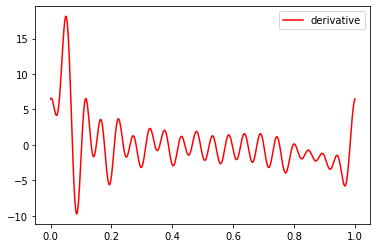

In [102]:
plt.plot(X, dY, color="red", label="derivative")
plt.legend();

In [103]:
f = lambda x: -np.dot(w, [np.cos(2*np.pi*x*i)for i in range(N_polynomials)] + [np.sin(2*np.pi*x*i) for i in range(N_polynomials)])
df = lambda x: -np.dot(w, [-2*np.pi*i*np.sin(2*np.pi*x*i)for i in range(N_polynomials)] + [2*np.pi*i*np.cos(2*np.pi*x*i) for i in range(N_polynomials)])

In [104]:
from scipy.optimize import minimize

In [105]:
res = minimize(f, 0, bounds=[(0, 0.1),])
res.x

array([0.07182741])

In [106]:
res.fun

array([-0.8010038])

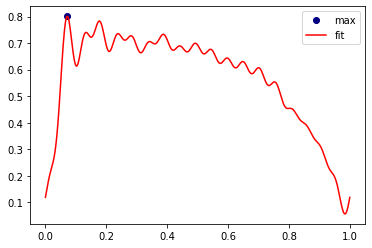

In [107]:
plt.plot(res.x, -res.fun, "o", color="navy", label="max")
plt.plot(X, Y, color="red", label="fit")
plt.legend();

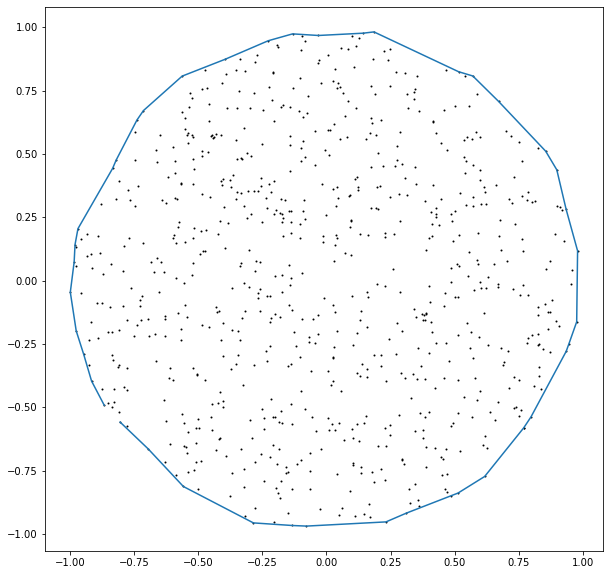

In [333]:
# https://stackoverflow.com/a/50714300/7200745
from scipy.spatial import Delaunay
import numpy as np

def alpha_shape(points, alpha, only_outer=True):
    """
    Compute the alpha shape (concave hull) of a set of points.
    :param points: np.array of shape (n,2) points.
    :param alpha: alpha value.
    :param only_outer: boolean value to specify if we keep only the outer border
    or also inner edges.
    :return: set of (i,j) pairs representing edges of the alpha-shape. (i,j) are
    the indices in the points array.
    """
    assert points.shape[0] > 3, "Need at least four points"

    def add_edge(edges, i, j):
        """
        Add an edge between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            assert (j, i) in edges, "Can't go twice over same directed edge right?"
            if only_outer:
                # if both neighboring triangles are in shape, it's not a boundary edge
                edges.remove((j, i))
            return
        edges.add((i, j))

    tri = Delaunay(points)
    edges = set()
    # Loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in tri.vertices:
        pa = points[ia]
        pb = points[ib]
        pc = points[ic]
        # Computing radius of triangle circumcircle
        # www.mathalino.com/reviewer/derivation-of-formulas/derivation-of-formula-for-radius-of-circumcircle
        a = np.sqrt((pa[0] - pb[0]) ** 2 + (pa[1] - pb[1]) ** 2)
        b = np.sqrt((pb[0] - pc[0]) ** 2 + (pb[1] - pc[1]) ** 2)
        c = np.sqrt((pc[0] - pa[0]) ** 2 + (pc[1] - pa[1]) ** 2)
        s = (a + b + c) / 2.0
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))
        circum_r = a * b * c / (4.0 * area)
        if circum_r < alpha:
            add_edge(edges, ia, ib)
            add_edge(edges, ib, ic)
            add_edge(edges, ic, ia)
    return edges

def find_edges_with(i, edge_set):
    i_first = [j for (x,j) in edge_set if x==i]
    i_second = [j for (j,x) in edge_set if x==i]
    return i_first,i_second

def stitch_boundaries(edges):
    edge_set = edges.copy()
    boundary_lst = []
    while len(edge_set) > 0:
        boundary = []
        edge0 = edge_set.pop()
        boundary.append(edge0)
        last_edge = edge0
        while len(edge_set) > 0:
            i,j = last_edge
            j_first, j_second = find_edges_with(j, edge_set)
            if j_first:
                edge_set.remove((j, j_first[0]))
                edge_with_j = (j, j_first[0])
                boundary.append(edge_with_j)
                last_edge = edge_with_j
            elif j_second:
                edge_set.remove((j_second[0], j))
                edge_with_j = (j, j_second[0])  # flip edge rep
                boundary.append(edge_with_j)
                last_edge = edge_with_j

            if edge0[0] == last_edge[1]:
                break

        boundary_lst.append(boundary)
    return boundary_lst[0]


#generating of random points
N = 1000
r = 1 - 2*np.random.random((N,2))
r_norm = np.linalg.norm(r, axis=1)
points = r[r_norm <= 1] 
plt.figure(figsize=(10,10))
plt.scatter(points[:,0], points[:,1], color='k', s=1)

#from 
# Computing the alpha shape
edges = alpha_shape(points, alpha=1, only_outer=True)
#order edges
edges = stitch_boundaries(edges)
# plt.axis('equal')
edge_points = np.zeros((len(edges),2))
k=0
for i, j in edges:
    edge_points[k,:] = points[[i, j], 0][0] , points[[i, j], 1][0]
    k += 1
plt.plot(edge_points[:,0],edge_points[:,1])

#theoretical edges
# xx = np.linspace(-1,1, 100)
# yy_upper =  np.sqrt(1 - xx**2)
# yy_lower = -np.sqrt(1 - xx**2)
# plt.plot(xx, yy_upper, 'r:')
# plt.plot(xx, yy_lower, 'b:')

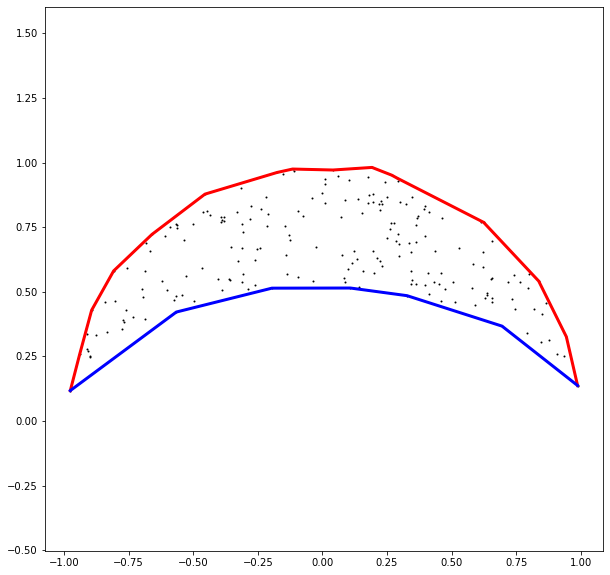

In [414]:
# https://stackoverflow.com/a/50714300/7200745
from scipy.spatial import Delaunay
import numpy as np

def alpha_shape(points, alpha, only_outer=True):
    """
    Compute the alpha shape (concave hull) of a set of points.
    :param points: np.array of shape (n,2) points.
    :param alpha: alpha value.
    :param only_outer: boolean value to specify if we keep only the outer border
    or also inner edges.
    :return: set of (i,j) pairs representing edges of the alpha-shape. (i,j) are
    the indices in the points array.
    """
    assert points.shape[0] > 3, "Need at least four points"

    def add_edge(edges, i, j):
        """
        Add an edge between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            assert (j, i) in edges, "Can't go twice over same directed edge right?"
            if only_outer:
                # if both neighboring triangles are in shape, it's not a boundary edge
                edges.remove((j, i))
            return
        edges.add((i, j))

    tri = Delaunay(points)
    edges = set()
    # Loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in tri.vertices:
        pa = points[ia]
        pb = points[ib]
        pc = points[ic]
        # Computing radius of triangle circumcircle
        # www.mathalino.com/reviewer/derivation-of-formulas/derivation-of-formula-for-radius-of-circumcircle
        a = np.sqrt((pa[0] - pb[0]) ** 2 + (pa[1] - pb[1]) ** 2)
        b = np.sqrt((pb[0] - pc[0]) ** 2 + (pb[1] - pc[1]) ** 2)
        c = np.sqrt((pc[0] - pa[0]) ** 2 + (pc[1] - pa[1]) ** 2)
        s = (a + b + c) / 2.0
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))
        circum_r = a * b * c / (4.0 * area)
        if circum_r < alpha:
            add_edge(edges, ia, ib)
            add_edge(edges, ib, ic)
            add_edge(edges, ic, ia)
    return edges



def find_edges_with(i, edge_set):
    i_first = [j for (x,j) in edge_set if x==i]
    i_second = [j for (j,x) in edge_set if x==i]
    return i_first,i_second

def stitch_boundaries(edges):
    edge_set = edges.copy()
    boundary_lst = []
    while len(edge_set) > 0:
        boundary = []
        edge0 = edge_set.pop()
        boundary.append(edge0)
        last_edge = edge0
        while len(edge_set) > 0:
            i,j = last_edge
            j_first, j_second = find_edges_with(j, edge_set)
            if j_first:
                edge_set.remove((j, j_first[0]))
                edge_with_j = (j, j_first[0])
                boundary.append(edge_with_j)
                last_edge = edge_with_j
            elif j_second:
                edge_set.remove((j_second[0], j))
                edge_with_j = (j, j_second[0])  # flip edge rep
                boundary.append(edge_with_j)
                last_edge = edge_with_j

            if edge0[0] == last_edge[1]:
                break

        boundary_lst.append(boundary)
    return boundary_lst[0]

#generating of random points
N = 1000
r = 1 - 2*np.random.random((N,2))
r_norm = np.linalg.norm(r, axis=1)
points = r[(r_norm <= 1) & (r[:,0]**2 + 4*r[:,1]**2 >=1) & (r[:,1]>0)] 
plt.figure(figsize=(10,10))
plt.scatter(points[:,0], points[:,1], color='k', s=1)

# Computing the alpha shape
edges = alpha_shape(points, alpha=1, only_outer=True)
#order edges
edges = stitch_boundaries(edges)
plt.axis('equal')
edge_points = np.zeros((len(edges),2))
k=0
for i, j in edges:
    edge_points[k,:] = points[[i, j], 0][0] , points[[i, j], 1][0]
    k += 1
plt.plot(edge_points[:,0],edge_points[:,1])

min_x_ind = np.argmin(edge_points[:, 0])
max_x_ind = np.argmax(edge_points[:, 0])
if min_x_ind < max_x_ind:
    lower_hull = edge_points[min_x_ind:max_x_ind+1, :]
    upper_hull = np.concatenate([edge_points[max_x_ind:, :], edge_points[:min_x_ind+1, :]])
else:
    upper_hull = edge_points[max_x_ind:min_x_ind+1, :]
    lower_hull = np.concatenate([edge_points[min_x_ind:, :], edge_points[:max_x_ind+1, :]])
    
plt.plot(upper_hull[:,0],upper_hull[:,1], "r", lw=3 )
plt.plot(lower_hull[:,0],lower_hull[:,1], "b", lw=3 )

#theoretical edges
# xx = np.linspace(-1,1, 100)
# yy_upper =  np.sqrt(1 - xx**2)
# yy_lower = -np.sqrt(1 - xx**2)
# plt.plot(xx, yy_upper, 'r:')
# plt.plot(xx, yy_lower, 'b:')
fig = go.Figure()
fig.add_trace(go.Scatter(x=upper_hull[:,0],y=upper_hull[:,1], mode='lines', line_color='indigo', fill='tozeroy')) # fill to trace0 y
fig.add_trace(go.Scatter(x=lower_hull[:,0],y=lower_hull[:,1], mode='lines', line_color='indigo', fill='tozeroy', fillcolor='rgba(0,0,100,0.1)')) # fill down to xaxis
layout = go.Layout(
#     paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,100,0.1)'
)
fig.update_layout(layout)

fig.show()

In [ ]:
# def smooth_in_mini_square(x, y, dx, dy):
# 	N = x.size
# 	points=np.c_[x,y]
# 	dl = np.sqrt(dx**2 + dy**2)
# 	xnew = np.zeros(N)
# 	ynew = np.zeros(N)
# 	for i,pi in enumerate(points):
# 		dist = np.linalg.norm(points - pi*np.ones((N,1)), axis=1)
# 		# print(dist)
# 		args = (dist < dl)
# 		# print(args)
# 		xnew[i] = x[args].mean()
# 		ynew[i] = y[args].mean()
# 	return xnew, ynew

# def get_item(item):
# 	x,y = item
# 	return (item[0], item[1])

# def sort_by_theta (arr, x_cm, shift=True):
# 	theta = np.arctan2(arr[:,1] - 0.25, arr[:,0] - x_cm)
# 	if shift: #shift from -pi,pi to 0, 2pi
# 		theta = np.where(theta<0 , 2*np.pi+theta, theta)
# 	print('thetaMinMax:', theta.min(), theta.max())
# 	args = (-theta).argsort(kind='mergesort')
# 	return arr[args]

# #sort and delete the same points
# def sort_by_three_part(x, y):
# 	arr = np.c_[x,y]
# 	print('arr.shape:',arr.shape)
# 	xmin = x.min()
# 	xmax = x.max()
	
# 	x_cm = 0.5*(xmin + xmax)

# 	#split points into 3 parts
# 	first_part  = arr[(y <  0.35) & (x <  x_cm)]
# 	second_part = arr[(y >= 0.35) & (x <  x_cm)]
# 	third_part  = arr[              (x >= x_cm)]

# 	#sort each part
# 	first_part = sort_by_theta(first_part, x_cm, shift=True) # sort by theta
# 	#The last column (or row if keys is a 2D array) is the primary sort key.
# 	second_part = second_part[np.lexsort((second_part[:,1],second_part[:,0]))] # sort by x
# 	third_part = sort_by_theta(third_part, x_cm, shift=False) # sort by theta
	
# 	#gather all points
# 	sorted_points = np.concatenate((first_part, second_part, third_part))
	
# 	#delete the same points
# 	jump = np.sqrt(np.diff(sorted_points[:,0])**2 + np.diff(sorted_points[:,1])**2)
# 	sorted_points = sorted_points[:-1]
# 	# smooth_jump = gaussian_filter1d(jump, 5, mode='wrap')  # window of size 5 is arbitrary
# 	# limit = 5*np.median(smooth_jump)    # factor 2 is arbitrary
# 	# sorted_points = sorted_points[(jump > 0) & (smooth_jump < limit)]
# 	sorted_points = sorted_points[jump>0]

# 	#find initial point
# 	x0, y0 = first_part[0]
# 	print('num_of_points=', arr.shape[0])
# 	print('Starting point:', x0, y0)
# 	print('MinMax point X:', xmin, xmax)

# 	#create stats file
# 	fn = "r_over_x_t={}.csv".format(timesteps[0])
# 	with open(fn, 'w') as f:
# 		f.write(json.dumps(sorted_points.tolist()))
# 	return sorted_points[:,0], sorted_points[:,1], x0, xmin, xmax
# '''
# 	msize = 0.2
# 	plt.figure()
# 	plt.plot(first_part[:,0], first_part[:,1], '-',  markersize=msize)
# 	plt.plot(second_part[:,0], second_part[:,1], '-',  markersize=msize)
# 	plt.plot(third_part[:,0], third_part[:,1], '-',  markersize=msize)
# 	plt.xlabel('x')
# 	plt.ylabel('Radius')
# 	plt.legend(['first_part', 'second_part', 'third_part', 'xz4', 'xz5'], loc='best')
# 	plt.grid()
# 	plt.savefig("test_parts.eps")
# '''




# def nearest_point(x, y, x0, y0):
# 	values = (x - x0)**2 + (y - y0)**2
# 	index_min = np.argmin(values)
# 	if values[index_min] > 0.01 and y0 > 0.35:
# 		print("ERROR!!!:",x[index_min], y[index_min], values[index_min])
# 		return None, None
# 	return x[index_min], y[index_min]

# def sort_by_nearest(x, y):
# 	aa = np.c_[x,y]
# 	aa = list(map(tuple, aa))
# 	aa = np.array(sorted(aa, key=lambda item: get_item(item)))
# 	x,y = aa[:,0], aa[:,1]
# 	xmin = x[0]
# 	xmax = x[-1]
# 	x_cm = 0.5*(xmin + xmax)

# 	#find initial point
# 	first_part  = aa[(y <  0.35) & (x <  x_cm)]
# 	first_part = sort_by_theta(first_part, x_cm, shift=True) # sort by theta
# 	x0, y0 = first_part[0]
# 	print('Starting point:', x0, y0)
# 	print('MinMax point X:', xmin, xmax)

# 	xx, yy = [], []
# 	x_copy, y_copy = np.copy(x), np.copy(y)
# 	for i,xi in enumerate(x_copy[:-1]):
# 		yi = y_copy[i]
# 		x_copy[i] = np.inf
# 		a,b = nearest_point(x_copy, y_copy, xi, yi)
# 		if a != None and b != None:
# 			xx.append(a)
# 			yy.append(b)
# 	# jump = np.sqrt(np.diff(sorted_points[:,0])**2 + np.diff(sorted_points[:,1])**2)
# 	# sorted_points = sorted_points[:-1]
# 	# smooth_jump = gaussian_filter1d(jump, 5, mode='wrap')  # window of size 5 is arbitrary
# 	# limit = 5*np.median(smooth_jump)    # factor 2 is arbitrary
# 	# sorted_points = sorted_points[(jump > 0) & (smooth_jump < limit)]
# 	# sorted_points = sorted_points[jump>0]

# 	return np.asarray(xx), np.asarray(yy), x0, xmin, xmax

# def sort_points(x, y):
# 	points = np.c_[x, y]

# 	clf = NearestNeighbors(2).fit(points)
# 	G = clf.kneighbors_graph()
# 	T = nx.from_scipy_sparse_matrix(G)

# 	order = list(nx.dfs_preorder_nodes(T, 0))

# 	xx = x[order]
# 	yy = y[order]

# 	# plt.plot(xx, yy, 'r.')
# 	# plt.savefig("test.png")
# 	# plt.show()

# 	paths = [list(nx.dfs_preorder_nodes(T, i)) for i in range(len(points))]

# 	mindist = np.inf
# 	minidx = 0

# 	for i in range(len(points)):
# 		p = paths[i]           # order of nodes
# 		ordered = points[p]    # ordered nodes
# 		# find cost of that order by the sum of euclidean distances between points (i) and (i+1)
# 		cost = (((ordered[:-1] - ordered[1:])**2).sum(1)).sum()
# 		if cost < mindist:
# 			mindist = cost
# 			minidx = i

# 	opt_order = paths[minidx]

# 	xx = x[opt_order]
# 	yy = y[opt_order]

# 	return xx, yy

# def non_uniform_savgol(x, y, window, polynom):
# 	"""
#     Applies a Savitzky-Golay filter to y with non-uniform spacing
#     as defined in x

#     This is based on https://dsp.stackexchange.com/questions/1676/savitzky-golay-smoothing-filter-for-not-equally-spaced-data
#     The borders are interpolated like scipy.signal.savgol_filter would do

#     Parameters
#     ----------
#     x : array_like
#         List of floats representing the x values of the data
#     y : array_like
#         List of floats representing the y values. Must have same length
#         as x
#     window : int (odd)
#         Window length of datapoints. Must be odd and smaller than x
#     polynom : int
#         The order of polynom used. Must be smaller than the window size

#     Returns
#     -------
#     np.array of float
#         The smoothed y values
#     """
# 	if len(x) != len(y):
# 		raise ValueError('"x" and "y" must be of the same size')

# 	if len(x) < window:
# 		raise ValueError('The data size must be larger than the window size')

# 	if type(window) is not int:
# 		raise TypeError('"window" must be an integer')

# 	if window % 2 == 0:
# 		raise ValueError('The "window" must be an odd integer')

# 	if type(polynom) is not int:
# 		raise TypeError('"polynom" must be an integer')

# 	if polynom >= window:
# 		raise ValueError('"polynom" must be less than "window"')

# 	half_window = window // 2
# 	polynom += 1

# 	# Initialize variables
# 	A = np.empty((window, polynom))     # Matrix
# 	tA = np.empty((polynom, window))    # Transposed matrix
# 	t = np.empty(window)                # Local x variables
# 	y_smoothed = np.full(len(y), np.nan)

# 	# Start smoothing
# 	for i in range(half_window, len(x) - half_window, 1):
# 		# Center a window of x values on x[i]
# 		for j in range(0, window, 1):
# 			t[j] = x[i + j - half_window] - x[i]

# 		# Create the initial matrix A and its transposed form tA
# 		for j in range(0, window, 1):
# 			r = 1.0
# 			for k in range(0, polynom, 1):
# 				A[j, k] = r
# 				tA[k, j] = r
# 				r *= t[j]

# 		# Multiply the two matrices
# 		tAA = np.matmul(tA, A)

# 		# Invert the product of the matrices
# 		tAA = np.linalg.inv(tAA)

# 		# Calculate the pseudoinverse of the design matrix
# 		coeffs = np.matmul(tAA, tA)

# 		# Calculate c0 which is also the y value for y[i]
# 		y_smoothed[i] = 0
# 		for j in range(0, window, 1):
# 			y_smoothed[i] += coeffs[0, j] * y[i + j - half_window]

# 		# If at the end or beginning, store all coefficients for the polynom
# 		if i == half_window:
# 			first_coeffs = np.zeros(polynom)
# 			for j in range(0, window, 1):
# 				for k in range(polynom):
# 					first_coeffs[k] += coeffs[k, j] * y[j]
# 		elif i == len(x) - half_window - 1:
# 			last_coeffs = np.zeros(polynom)
# 			for j in range(0, window, 1):
# 				for k in range(polynom):
# 					last_coeffs[k] += coeffs[k, j] * y[len(y) - window + j]

# 	# Interpolate the result at the left border
# 	for i in range(0, half_window, 1):
# 		y_smoothed[i] = 0
# 		x_i = 1
# 		for j in range(0, polynom, 1):
# 			y_smoothed[i] += first_coeffs[j] * x_i
# 			x_i *= x[i] - x[half_window]

# 	# Interpolate the result at the right border
# 	for i in range(len(x) - half_window, len(x), 1):
# 		y_smoothed[i] = 0
# 		x_i = 1
# 		for j in range(0, polynom, 1):
# 			y_smoothed[i] += last_coeffs[j] * x_i
# 			x_i *= x[i] - x[-half_window - 1]

# 	return y_smoothed



# def calc_delta(x, y, x0, x_rmax, x_cm):
# 	#     mask = np.logical_and(x >= x_rmax + x0, x <= x_cm + x0)   
# 	mask = (x >= x_rmax + x0) * (x <= x_cm + x0) * (y>=0.35)
# 	delta_min = 0.5 - max(y[mask])
# 	delta_max = 0.5 - min(y[mask])
# 	print('***yMINMAX',min(y[mask]),max(y[mask]))
# 	print('----xMINMAX', min(x[mask]), max(x[mask]))

# 	ss = np.trapz(y=y[mask], x=x[mask])   

# 	#     L = x_cm - x_rmax
# 	L = x[mask][-1] - x[mask][0]
# 	rad_mean = ss/L
# 	delta_mean = 0.5 - rad_mean
# 	print('S=', ss, ' L=', L, 'x_cm=', x_cm, 'x_rmax=', x_rmax, 'rad_mean=', rad_mean, 'delta_mean=', delta_mean)
# 	print('delta_min=', delta_min, 'delta_max=', delta_max, 'delta_mean=', delta_mean)
# 	return delta_min, delta_max, delta_mean 








# '''
# msize = 0.02
# lwidth = 0.1
# plt.figure()
# #plot raw points
# plt.plot(x, y, 'b.',  markersize=msize,  linewidth=lwidth, label='raw')
# #plot after smoothing
# plt.plot(XX, YY, 'k-',  markersize=msize,  linewidth=lwidth, label='smoothed line')
# #plot vertical lines
# plt.plot([x_peak, x_peak], [0,0.5], 'b:',  markersize=msize,  linewidth=0.5)
# plt.plot([x_mean, x_mean], [0,0.5], 'b:',  markersize=msize,  linewidth=0.5)
# plt.xlabel('x')
# plt.ylabel('Radius')
# plt.ylim(0, 0.5)
# plt.grid()
# plt.legend(['original', 'smoothed line'], loc='lower center')
# fn = "graph_r_over_x_t" + str(timesteps[0]) + ".eps"
# plt.savefig(fn)
# '''
